Device: cpu
Number of CPU cores: 8
No GPU available
Hyperparameters:
{'batch_size': 64,
 'fc1_size': 512,
 'image_size': 56,
 'lr': 0.001,
 'num_epochs': 3}
Running solution 1/5


Epoch [1/3]: Train Loss: 0.6044, Val Loss: 0.2353, Remaining Time: 1m 32s


Epoch [2/3]: Train Loss: 0.1879, Val Loss: 0.1590, Remaining Time: 0m 47s


Epoch [3/3]: Train Loss: 0.1573, Val Loss: 0.1445, Remaining Time: 0m 0s
Accuracy on the test set: 80.45%
Precision: 0.77, Recall: 0.98, F1 score: 0.86


<Figure size 640x480 with 0 Axes>

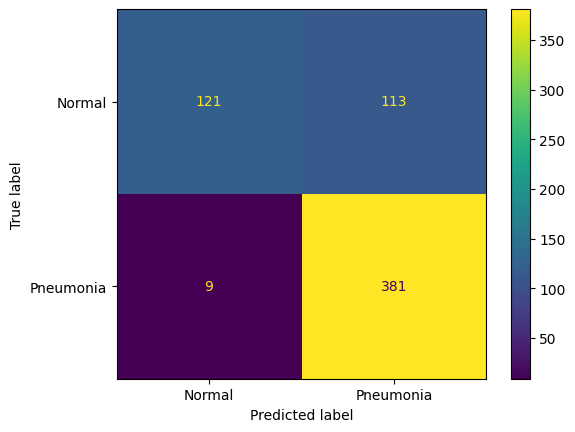

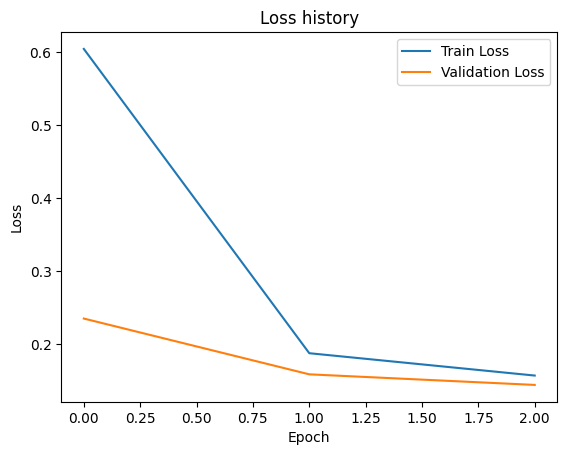

F1 = 0.86, accuracy = 0.80 
Running solution 2/5


Epoch [1/3]: Train Loss: 0.6420, Val Loss: 0.2312, Remaining Time: 1m 33s


Epoch [2/3]: Train Loss: 0.2032, Val Loss: 0.1476, Remaining Time: 0m 45s


Epoch [3/3]: Train Loss: 0.1788, Val Loss: 0.1321, Remaining Time: 0m 0s
F1 = 0.83, accuracy = 0.74 
Running solution 3/5


Epoch [1/3]: Train Loss: 0.8151, Val Loss: 0.3162, Remaining Time: 1m 28s


Epoch [2/3]: Train Loss: 0.2486, Val Loss: 0.1908, Remaining Time: 0m 44s


Epoch [3/3]: Train Loss: 0.1737, Val Loss: 0.1499, Remaining Time: 0m 0s
F1 = 0.84, accuracy = 0.77 
Running solution 4/5


Epoch [1/3]: Train Loss: 0.8793, Val Loss: 0.3901, Remaining Time: 1m 47s


Epoch [2/3]: Train Loss: 0.2999, Val Loss: 0.2526, Remaining Time: 0m 51s


Epoch [3/3]: Train Loss: 0.2164, Val Loss: 0.3866, Remaining Time: 0m 0s
F1 = 0.78, accuracy = 0.65 
Running solution 5/5


Epoch [1/3]: Train Loss: 0.7323, Val Loss: 0.2760, Remaining Time: 2m 6s


Epoch [2/3]: Train Loss: 0.2410, Val Loss: 0.1648, Remaining Time: 0m 56s


Epoch [3/3]: Train Loss: 0.1830, Val Loss: 0.1502, Remaining Time: 0m 0s
F1 = 0.86, accuracy = 0.80 
Results
F1 List: [0.86199095 0.82566845 0.83991228 0.78269618 0.86009174]
Accuracy List: [0.80448718 0.73878205 0.76602564 0.65384615 0.80448718]
F1: 83.4% (+-2.9%)
Accuracy: 75.4% (+-5.6%)
Time of one solution: 2m 39s
 | 83.4% (+-2.9%) | 75.4% (+-5.6%) | 2m 39s


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import random_split
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm
import time
import random
import os
import matplotlib.pyplot as plt
import numpy as np
import pprint

h = {
    "num_epochs": 3,
    "batch_size": 64,
    "image_size": 56,
    "fc1_size": 512,
    "lr": 0.001
}

def extract_patient_ids(filename):
    patient_id = filename.split('_')[0].replace("person", "")
    return patient_id

def split_file_names(input_folder, val_split_perc):
    # Pneumonia files contain patient id, so we group split them by patient to avoid data leakage
    pneumonia_patient_ids = set([extract_patient_ids(fn) for fn in os.listdir(os.path.join(input_folder, 'PNEUMONIA'))])
    pneumonia_val_patient_ids = random.sample(list(pneumonia_patient_ids), int(val_split_perc * len(pneumonia_patient_ids)))

    pneumonia_val_filenames = []
    pneumonia_train_filenames = []

    for filename in os.listdir(os.path.join(input_folder, 'PNEUMONIA')):
        patient_id = extract_patient_ids(filename)
        if patient_id in pneumonia_val_patient_ids:
            pneumonia_val_filenames.append(os.path.join(input_folder, 'PNEUMONIA', filename))
        else:
            pneumonia_train_filenames.append(os.path.join(input_folder, 'PNEUMONIA', filename))

    # Normal (by file, no patient information in file names)
    normal_filenames  = [os.path.join(input_folder, 'NORMAL', fn) for fn in os.listdir(os.path.join(input_folder, 'NORMAL'))]
    normal_val_filenames = random.sample(normal_filenames, int(val_split_perc * len(normal_filenames)))
    normal_train_filenames = list(set(normal_filenames)-set(normal_val_filenames))

    train_filenames = pneumonia_train_filenames + normal_train_filenames
    val_filenames = pneumonia_val_filenames + normal_val_filenames

    return train_filenames, val_filenames

def prepare_data(h):
    data_transforms = transforms.Compose([
        transforms.Resize(size=(h["image_size"], h["image_size"])),
        transforms.ToTensor(),
    ])

    # Define the validation split percentage
    val_split = 0.2
    train_filenames, val_filenames = split_file_names("C:\\Users\\Омар\\PycharmProjects\\FinalMLProject\\chest_xray\\chest_xray\\train\\", val_split)

    # Load the datasets
    train_dataset = datasets.ImageFolder("C:\\Users\\Омар\\PycharmProjects\\FinalMLProject\\chest_xray\\chest_xray\\train\\", 
                                         transform=data_transforms, 
                                         is_valid_file=lambda x: x in train_filenames)
    val_dataset = datasets.ImageFolder("C:\\Users\\Омар\\PycharmProjects\\FinalMLProject\\chest_xray\\chest_xray\\train\\", 
                                       transform=data_transforms, 
                                       is_valid_file=lambda x: x in val_filenames)    
    test_dataset = datasets.ImageFolder("C:\\Users\\Омар\\PycharmProjects\\FinalMLProject\\chest_xray\\chest_xray\\test\\", 
                                        transform=data_transforms)

    # Create the data loaders for train, validation, and test sets
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=h["batch_size"], shuffle=True, num_workers=4)    
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=h["batch_size"], shuffle=True, num_workers=4)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=h["batch_size"], shuffle=True, num_workers=4)

    return train_loader, val_loader, test_loader

def create_model(h, device):
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(3 * h["image_size"] * h["image_size"], h["fc1_size"]),
        nn.ReLU(),
        nn.Linear(h["fc1_size"], 2)
    )
    model = model.to(device)
    return model

def train_model(h, model, train_loader, val_loader, optimizer, criterion, device):
    train_loss_history = []
    val_loss_history = []

    start_time = time.time()
    num_epochs = h["num_epochs"]

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        progress_bar = tqdm(train_loader, desc=f"Training epoch {epoch + 1}/{num_epochs}", leave=False, unit="mini-batch")
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)      
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            progress_bar.set_postfix(loss=loss.item())


        val_loss, _, _, _ = evaluate_model(h, model, val_loader, criterion, device)
        
        # Store the loss history
        train_loss = running_loss / len(train_loader)
        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)

        # Calculate elapsed time and remaining time
        elapsed_time = time.time() - start_time
        avg_time_per_epoch = elapsed_time / (epoch + 1)
        remaining_epochs = num_epochs - (epoch + 1)
        remaining_time = avg_time_per_epoch * remaining_epochs

        # Convert remaining time to minutes and seconds
        remaining_time_min, remaining_time_sec = divmod(remaining_time, 60)

        print(f"Epoch [{epoch + 1}/{num_epochs}]: Train Loss: {running_loss / len(train_loader):.4f}, Val Loss: {val_loss:.4f}, Remaining Time: {remaining_time_min:.0f}m {remaining_time_sec:.0f}s")

    return train_loss_history, val_loss_history

def evaluate_model(h, model, data_loader, criterion, device):
    true_labels = []
    predicted_labels = []
    total_loss = 0.0
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)          

            outputs = model(inputs)

            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

    epoch_loss = total_loss / len(data_loader)
    epoch_accuracy = correct / total

    return epoch_loss, epoch_accuracy, true_labels, predicted_labels

def plot_metrics(h, train_loss_history, val_loss_history, test_loss, test_accuracy, true_labels, predicted_labels):
    print(f"Accuracy on the test set: {test_accuracy:.2%}")

    # Calculate precision, recall, and F1 score using the accumulated true labels and predictions
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)
    print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1 score: {f1:.2f}")

    # Calculate the confusion matrix using the accumulated true labels and predictions
    cm = confusion_matrix(true_labels, predicted_labels)

    # Visualize the confusion matrix
    plt.figure()
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Pneumonia"])
    disp.plot()

    # Plot the learning curves
    plt.figure()
    plt.plot(train_loss_history, label='Train Loss')
    plt.plot(val_loss_history, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss history')
    plt.legend()
    plt.show()  

def check_solution(h, device, verbose):
    train_loader, val_loader, test_loader = prepare_data(h)
    model = create_model(h, device)
    optimizer = torch.optim.Adam(model.parameters(), lr=h["lr"])
    criterion = nn.CrossEntropyLoss()
    train_loss_history, val_loss_history = train_model(h, model, train_loader, val_loader, optimizer, criterion, device)
    test_loss, test_accuracy, true_labels, predicted_labels = evaluate_model(h, model, test_loader, criterion, device)
    if verbose:
        plot_metrics(h, train_loss_history, val_loss_history, test_loss, test_accuracy, true_labels, predicted_labels)

    f1 = f1_score(true_labels, predicted_labels)

    return f1, test_accuracy


# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# Get number of CPU cores
num_cpu_cores = os.cpu_count()
print(f"Number of CPU cores: {num_cpu_cores}")

# Get GPU name
if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    print(f"GPU name: {gpu_name}")
else:
    print("No GPU available")

# Print hyperparameters for records
print("Hyperparameters:")
pprint.pprint(h)

f1_array = np.array([])
accuracy_array = np.array([])
start_time = time.time()

repeats = 5
for i in range(repeats):
    print(f"Running solution {i+1}/{repeats}")
    f1, accuracy = check_solution(h, device, verbose=(i==0))
    print(f"F1 = {f1:.2f}, accuracy = {accuracy:.2f} ")
    f1_array = np.append(f1_array, f1)
    accuracy_array = np.append(accuracy_array, accuracy) 

# Calculate elapsed time and remaining time
repeat_time = (time.time() - start_time) / repeats
repeat_time_min, repeat_time_sec = divmod(repeat_time, 60)

# Printing final results
print("Results")
print(f"F1 List: {f1_array}")
print(f"Accuracy List: {accuracy_array}")
print(f"F1: {np.mean(f1_array):.1%} (+-{np.std(f1_array):.1%})")
print(f"Accuracy: {np.mean(accuracy_array):.1%} (+-{np.std(accuracy_array):.1%})")
print(f"Time of one solution: {repeat_time_min:.0f}m {repeat_time_sec:.0f}s")

print(f" | {np.mean(f1_array):.1%} (+-{np.std(f1_array):.1%}) | {np.mean(accuracy_array):.1%} (+-{np.std(accuracy_array):.1%}) | {repeat_time_min:.0f}m {repeat_time_sec:.0f}s")